# Interacting with ProtoDash

In this notebook we'll combine the ProtoDash and the Partial Effects to obtain feature importances on the digits classifications task.

ProtoDash was proposed in _Gurumoorthy, Karthik & Dhurandhar, Amit & Cecchi, Guillermo & Aggarwal, Charu. (2019). Efficient Data Representation by Selecting Prototypes with Importance Weights. 260-269. 10.1109/ICDM.2019.00036_.

In [1]:
import numpy  as np
import pandas as pd

# automatically differentiable implementation of numpy
import jax.numpy as jnp

import shap

from sklearn import datasets

from sklearn.model_selection import train_test_split
from IPython.display         import display, Math, Latex

import matplotlib.pyplot as plt

from itea.classification import ITEA_classifier
from itea.inspection     import *

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

from aix360.algorithms.protodash import ProtodashExplainer, get_Gaussian_Data

In [2]:
digits_data = datasets.load_digits(n_class=10)

X, y        = digits_data['data'], digits_data['target']
labels      = digits_data['feature_names']
targets     = digits_data['target_names']

X /= X.max(axis=1).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

print(X_train.shape)

# Creating transformation functions for ITEA using jax.numpy
# (so we don't need to analytically calculate its derivatives)
tfuncs = {
    'id' : lambda x: x
}

clf = ITEA_classifier(
    gens            = 300,
    popsize         = 300,
    max_terms       = 10,
    expolim         = (0, 1),
    verbose         = 5,
    tfuncs          = tfuncs,
    labels          = labels,
    simplify_method = None,
    random_state    = 42,
    fit_kw          = {'max_iter' : 5}
).fit(X_train, y_train)

(1203, 64)
gen 	 min_fitness 	 mean_fitness 	 max_fitness 	 remaining (s)
0 	 0.1055694098088113 	 0.10556940980881134 	 0.1055694098088113 	 6min51seg
5 	 0.1055694098088113 	 0.10556940980881134 	 0.1055694098088113 	 7min59seg
10 	 0.1055694098088113 	 0.10556940980881134 	 0.1055694098088113 	 8min11seg
15 	 0.1055694098088113 	 0.10556940980881134 	 0.1055694098088113 	 8min29seg
20 	 0.1055694098088113 	 0.1092269326683292 	 0.1512884455527847 	 8min27seg
25 	 0.1055694098088113 	 0.15486007204211696 	 0.2734829592684954 	 8min54seg
30 	 0.1512884455527847 	 0.2430811859240787 	 0.32751454696591853 	 9min12seg
35 	 0.2734829592684954 	 0.2987143252978664 	 0.3507896924355777 	 10min33seg
40 	 0.2635078969243558 	 0.3326932668329178 	 0.40980881130507063 	 11min11seg
45 	 0.3341645885286783 	 0.3718814075921308 	 0.4613466334164589 	 10min55seg
50 	 0.3782211138819618 	 0.4164921030756442 	 0.514546965918537 	 11min50seg
55 	 0.39900249376558605 	 0.48183153228041004 	 0.552784704

It wasn't specified a dict for tfuncs_dx. They will be automatically generated using Jax. For this, make sure that the tfuncs uses the jax.numpy instead of numpy to create the transformation functions. You can access the automatic derivatives with explainer.tfuncs_dx.


In [3]:
final_itexpr = clf.bestsol_
final_itexpr.selected_features_

array(['pixel_0_4', 'pixel_1_2', 'pixel_2_5', 'pixel_3_2', 'pixel_3_4',
       'pixel_4_4', 'pixel_4_5', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3',
       'pixel_5_6', 'pixel_6_2', 'pixel_7_4', 'pixel_7_5'], dtype='<U9')

In [4]:
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(
    np.hstack( (X_train, y_train.reshape(-1, 1)) ) )

explainer = ProtodashExplainer()

# call protodash explainer. We'll select 10 prototypes
# S contains indices of the selected prototypes
# W contains importance weights associated with the selected prototypes 
(W, S, _) = explainer.explain(onehot_encoded, onehot_encoded, m=10)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


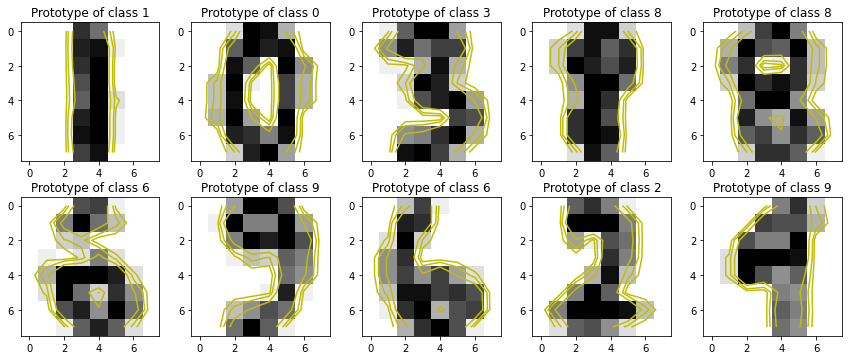

In [8]:
from matplotlib import cm

fig, axs = plt.subplots(2, 5, figsize=(12,5))

# Showing 10 prototypes
for s, ax in zip(S, fig.axes):
    ax.imshow(X_train[s].reshape(8, 8), cmap='gray_r')
    ax.set_title(f"Prototype of class {y_train[s]}")
    
    Z = X_train[s].reshape(8, 8)
    levels = [0.1, 0.2, 0.4]

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.PRGn

    cset2 = ax.contour(Z, levels, colors='y')

    for c in cset2.collections:
        c.set_linestyle('solid')


plt.tight_layout()
plt.show()

It wasn't specified a dict for tfuncs_dx. They will be automatically generated using Jax. For this, make sure that the tfuncs uses the jax.numpy instead of numpy to create the transformation functions. You can access the automatic derivatives with explainer.tfuncs_dx.


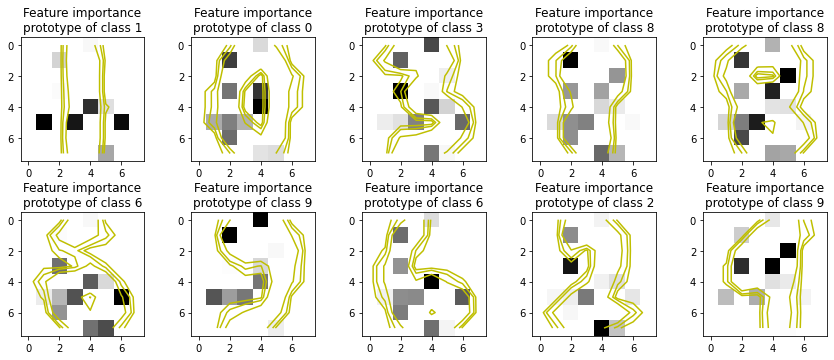

In [6]:
it_explainer = ITExpr_explainer(
    itexpr=final_itexpr,
    tfuncs=tfuncs
).fit(X_train, y_train)

fig, axs = plt.subplots(2, 5, figsize=(12,5))

for s, ax in zip(S, fig.axes):
    
    importances = it_explainer.average_partial_effects(X_train[s, :].reshape(1, -1))[y_train[s]]
    
    ax.imshow(importances.reshape(8, 8), cmap='gray_r')
    ax.set_title(f"Feature importance\nprototype of class {y_train[s]}")
    
    Z = X_train[s].reshape(8, 8)
    levels = [0.1, 0.2, 0.4]

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.PRGn

    cset2 = ax.contour(Z, levels, colors='y')

    for c in cset2.collections:
        c.set_linestyle('solid')
    
plt.tight_layout()
plt.show()

In [ ]:
it_explainer = ITExpr_explainer(
    itexpr=final_itexpr,
    tfuncs=tfuncs
).fit(X_train, y_train)

fig, axs = plt.subplots(2, 5, figsize=(12,5))

for c, ax in zip(final_itexpr.classes_, fig.axes):
    
    c_idx = np.array([i for i in range(len(y_train)) if y_train[i]==c])
    
    importances = it_explainer.average_partial_effects(X_train[c_idx, :])[c]
    
    ax.imshow(importances.reshape(8, 8), cmap='gray_r')
    ax.set_title(f"Feature importance\nprototype of class {c}")
    
    Z = X_train[c_idx, :].mean(axis=0).reshape(8, 8)
    levels = [0.1, 0.2, 0.4]

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.PRGn

    cset2 = ax.contour(Z, levels, colors='y')

    for c in cset2.collections:
        c.set_linestyle('solid')
    
plt.tight_layout()
plt.show()

It wasn't specified a dict for tfuncs_dx. They will be automatically generated using Jax. For this, make sure that the tfuncs uses the jax.numpy instead of numpy to create the transformation functions. You can access the automatic derivatives with explainer.tfuncs_dx.
